In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [2]:
# set basic parameters and subdirectory
part_n = 300
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
interval_len = 900
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}_".format(ei_std_s[0],
                                        ei_std_s[1])
                + "{:n}/".format(interval_len))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1694802946#round(time.time())
subdirectory = subdirectory + "{:n}".format(seed) + "/"
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
300_0.8_4_4-4_900/1694802946/


In [4]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 3
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, 
          ext_part_n, ext_sub_part_r_s,
          ext_sub_part_n_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          ext_connectivity_s)

phase_n = 3
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.4, 0.8]), 1) # or (wave_n, ext_part_n) arrays so different ext parts have different amps
freq_s = jnp.full(amp_s.shape, 0.)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

initial_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
initial_condition_n_free = initial_condition_n * ext_condition_n
[initial_condition_s, key] = initial_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           initial_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          initial_condition_n,
          ext_condition_n, initial_condition_n_free,
          initial_condition_s)

condition_s = jnp.asarray([1, 1])
condition_s_free = jnp.asarray([0, 0])
time_interval_s = jnp.asarray([[0,300], [300,interval_len]])
jnp.savez(subdirectory + "parameter_s_6.npz",
          condition_s, condition_s_free,
          time_interval_s)
labeled_time_interval_s = [time_interval_s, condition_s]
labeled_time_interval_s_free = [time_interval_s, condition_s_free]

resolution = 24
frame_gap = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution, frame_gap)

In [3]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, 
 ext_part_n, ext_sub_part_r_s,
 ext_sub_part_n_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[initial_condition_n,
 ext_condition_n, initial_condition_n_free,
 initial_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[condition_s, condition_s_free,
 time_interval_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, condition_s]
labeled_time_interval_s_free = [time_interval_s, condition_s_free]

[resolution, frame_gap] = load_as_list(subdirectory + "parameter_s_7.npz")

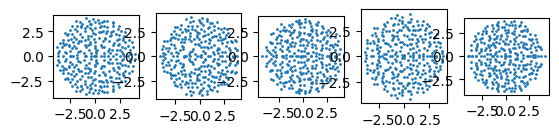

In [4]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n))
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx].set_aspect('equal')

In [6]:
# run and save trajs
traj_s_free = low_res_traj_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], initial_condition_s,
                       labeled_time_interval_s_free, resolution, frame_gap)
np.savez_compressed(subdirectory + "trajs_free.npz", traj_s_free) # jax has not implemented savez_compressed as of 23/08/23

traj_s = low_res_traj_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, initial_condition_s[::ext_condition_n],
                            labeled_time_interval_s, resolution, frame_gap)
np.savez_compressed(subdirectory + "trajs.npz", traj_s)

[5, 'connectivity_n']
[3, 'wave_n']
[3, 'ext_connectivity_n']
[3, 'phase_n']
[5, 'initial_condition_n']
0,1.87 mins
1,1.87 mins
2,1.88 mins
3,1.90 mins
4,1.90 mins


In [27]:
# load trajs
[traj_s_free] = load_as_list(subdirectory + "trajs_free.npz")
[traj_s] = load_as_list(subdirectory + "trajs.npz")

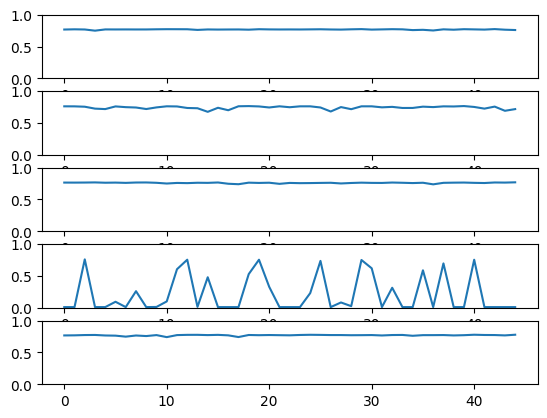

In [29]:
[fig, subfig_s] = plt.subplots(int(connectivity_n),1)
for connectivity_idx in range(connectivity_n):
  subfig_s[connectivity_idx].plot(jnp.var(traj_s_free[connectivity_idx,0,0,0], axis = (-2, -1)))
  subfig_s[connectivity_idx].set_ylim(0,1)

means and pcs and stats

In [7]:
short_interval_len_s = jnp.asarray([1,2,5,10])#jnp.asarray([1,2,3,4,5,6,10,12,15,20,30,60])
short_interval_n_s = 10 // short_interval_len_s
short_interval_len_n = short_interval_len_s.shape[0]

In [8]:
# reshape for Ts
condition_n_s_free = (connectivity_n, 1, 1, 1, initial_condition_n_free)
condition_n_s = (connectivity_n, wave_n, ext_connectivity_n, phase_n, initial_condition_n)

traj_s_free_reshaped = jnp.swapaxes(traj_s_free.reshape(condition_n_s_free + (part_n, 10, 60)), -2, -3)
traj_s_reshaped = jnp.swapaxes(traj_s.reshape(condition_n_s + (part_n, 10, 60)), -2, -3)

In [10]:
# basic stats
mean_s_free = mean_s_fct(traj_s_free_reshaped)
mean_s = mean_s_fct(traj_s_reshaped)
cov_s_free = cov_s_fct(traj_s_free_reshaped, mean_s_free)
cov_s = cov_s_fct(traj_s_reshaped, mean_s)

In [11]:
# eigenvalue stats
tr_s_free = np.zeros((short_interval_len_n, )+condition_n_s_free)
tr_s = np.zeros((short_interval_len_n, )+condition_n_s)
pr_s_free = np.zeros((short_interval_len_n, )+condition_n_s_free)
pr_s = np.zeros((short_interval_len_n, )+condition_n_s)

for short_interval_len_idx in range(short_interval_len_n):
  short_interval_len = short_interval_len_s[short_interval_len_idx]
  short_interval_n = short_interval_n_s[short_interval_len_idx]
  cov_s_longer_free = jnp.mean(cov_s_free.reshape(condition_n_s_free 
                                                  + (short_interval_n, short_interval_len, part_n, part_n)),
                               axis = -3)
  cov_s_longer = jnp.mean(cov_s.reshape(condition_n_s 
                                        + (short_interval_n, short_interval_len, part_n, part_n)),
                               axis = -3)
  pc_var_s_free = es_s_fct(cov_s_longer_free)[0]
  pc_var_s = es_s_fct(cov_s_longer)[0]
  tr_s_free[short_interval_len_idx] = jnp.mean(size_s_fct(pc_var_s_free), axis = -1)
  tr_s[short_interval_len_idx] = jnp.mean(size_s_fct(pc_var_s), axis = -1)
  pr_s_free[short_interval_len_idx] = jnp.mean(dim_r_s_fct(pc_var_s_free), axis = -1)
  pr_s[short_interval_len_idx] = jnp.mean(dim_r_s_fct(pc_var_s), axis = -1)

np.savez_compressed(subdirectory + "trs_prs.npz", tr_s_free, tr_s, pr_s_free, pr_s)

In [15]:
# load ea stats
[tr_s_free_foo, tr_s_foo, pr_s_free_foo, pr_s_foo] = load_as_list(subdirectory + "trs_prs.npz")

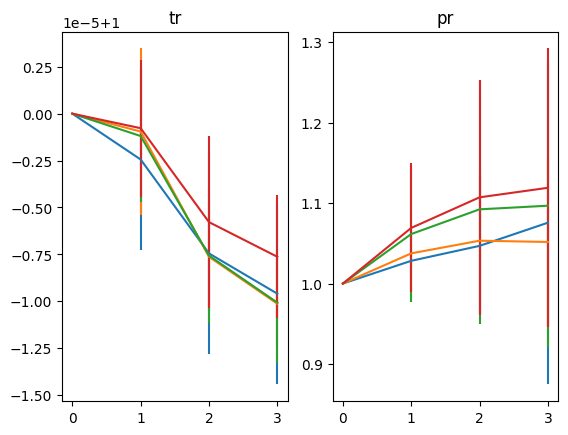

In [24]:
tr_stat_s_free = [jnp.mean(tr_s_free/tr_s_free[0:1], axis = (1,3,4,5)),
                 jnp.std(tr_s_free/tr_s_free[0:1], axis = (1,3,4,5))]
tr_stat_s = [jnp.mean(tr_s/tr_s[0:1], axis = (1,3,4,5)),
            jnp.std(tr_s/tr_s[0:1], axis = (1,3,4,5))]
tr_stat_s_all = [jnp.concatenate([tr_stat_s_free[idx], tr_stat_s[idx]], axis = -1) for idx in range(2)]

pr_stat_s_free = [jnp.mean(pr_s_free/pr_s_free[0:1], axis = (1,3,4,5)),
                 jnp.std(pr_s_free/pr_s_free[0:1], axis = (1,3,4,5))]
pr_stat_s = [jnp.mean(pr_s/pr_s[0:1], axis = (1,3,4,5)),
            jnp.std(pr_s/pr_s[0:1], axis = (1,3,4,5))]
pr_stat_s_all = [jnp.concatenate([pr_stat_s_free[idx], pr_stat_s[idx]], axis = -1) for idx in range(2)]

[fig, subfig_s] = plt.subplots(1, 2)
subfig_s[0].title.set_text("tr")
subfig_s[1].title.set_text("pr")
for wave_idx in range(wave_n+1):
  subfig_s[0].errorbar(jnp.arange(short_interval_len_n),tr_stat_s_all[0][:,wave_idx],yerr = tr_stat_s_all[1][:,wave_idx])
  subfig_s[1].errorbar(jnp.arange(short_interval_len_n),pr_stat_s_all[0][:,wave_idx],yerr = pr_stat_s_all[1][:,wave_idx])